In [1]:
import splitfolders

In [2]:
splitfolders.ratio("data", # The location of dataset
                   output="Train_data", # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

Copying files: 1803 files [00:24, 72.28 files/s]


In [1]:
import numpy as np  
import pandas as pd 
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam

In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("Train_data"))

['test', 'train', 'val']


In [3]:
#preproessing-img aumentation----avoid overfitting
from keras.preprocessing.image import ImageDataGenerator


train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('Train_data/train', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=12,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 1261 images belonging to 3 classes.


In [4]:
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

test_generator=test_datagen.flow_from_directory('Train_data/test', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=5,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 183 images belonging to 3 classes.


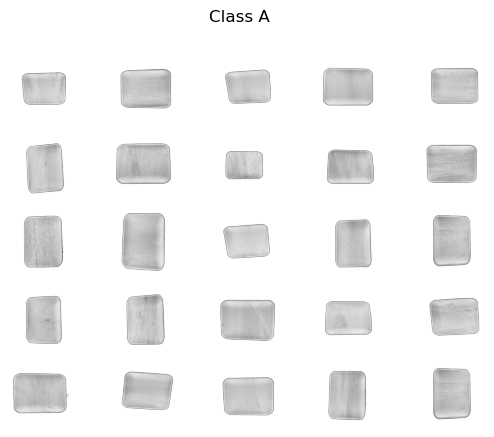

In [5]:
import os
import random
import matplotlib.pyplot as plt
normal_img = os.listdir('Train_data/train/Class A/')
random = random.sample(normal_img,25)
f,ax = plt.subplots(5,5)

for i in range(0,25):
    im = plt.imread('Train_data/train/Class A/'+random[i])
    ax[i//5,i%5].imshow(im)
    ax[i//5,i%5].axis('off')
f.suptitle('Class A')
plt.show()

In [6]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.models import Sequential

base_model=MobileNet( weights='imagenet',include_top=False,input_shape=(224,224,3)) #imports the mobilenet model and discards the last 1000 neuron layer.

In [7]:
x=base_model.output
x=GlobalAveragePooling2D()(x)

x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3

preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

In [8]:
model=Model(inputs=base_model.input,outputs=preds)
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [9]:
from keras.optimizers import Adam
from keras.callbacks import  EarlyStopping
Adam=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=False)
es = EarlyStopping(patience=5)
Adam

In [10]:
model.compile(optimizer=Adam,loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

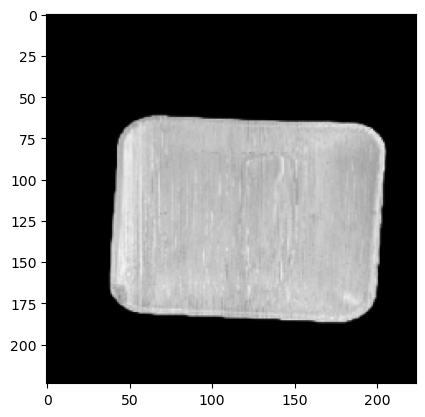

(1, 224, 224, 3)


In [11]:
from keras.utils import load_img, img_to_array
step_size_train=train_generator.n//train_generator.batch_size
step_size_test=test_generator.n//test_generator.batch_size
#viszualization

img_path='Train_data/val/Class A/image00003 (1).jpg'
img = load_img(img_path,target_size=(224,224))


img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()
print(img_tensor.shape)

In [12]:
history = model.fit(train_generator,
              epochs=15,
              batch_size=13,
              validation_data=test_generator,
              callbacks=[es])

Epoch 1/15
106/106 [==============================] - 89s 825ms/step - loss: 0.3784 - accuracy: 0.8557 - val_loss: 1.7831 - val_accuracy: 0.4809
Epoch 2/15
106/106 [==============================] - 88s 828ms/step - loss: 0.1849 - accuracy: 0.9389 - val_loss: 0.1777 - val_accuracy: 0.9344
Epoch 3/15
106/106 [==============================] - 91s 862ms/step - loss: 0.1693 - accuracy: 0.9429 - val_loss: 0.1041 - val_accuracy: 0.9454
Epoch 4/15
106/106 [==============================] - 101s 951ms/step - loss: 0.1858 - accuracy: 0.9262 - val_loss: 0.1470 - val_accuracy: 0.9617
Epoch 5/15
106/106 [==============================] - 104s 984ms/step - loss: 0.1270 - accuracy: 0.9572 - val_loss: 0.0992 - val_accuracy: 0.9727
Epoch 6/15
106/106 [==============================] - 100s 942ms/step - loss: 0.1187 - accuracy: 0.9572 - val_loss: 0.1219 - val_accuracy: 0.9563
Epoch 7/15
106/106 [==============================] - 104s 983ms/step - loss: 0.1250 - accuracy: 0.9500 - val_loss: 0.0911 - va

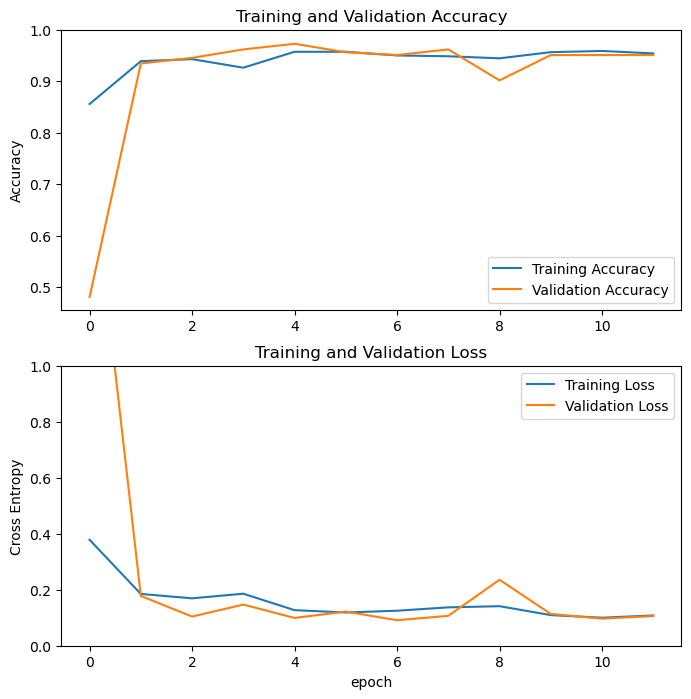

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [14]:

# Save the trained model
model.save("trained_model.h5")


In [1]:
from tensorflow.keras.models import load_model

model = load_model('trained_model.h5')


In [2]:
import os
from flask import Flask, request, render_template
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np



In [3]:

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

def preprocess_image(img):
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img


In [4]:

def predict_class(img_path):
    img = preprocess_image(img_path)
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions)
    return predicted_class


In [5]:
image_paths = ['Img1.jpg', 'Img2.jpg', 'Img5.jpg']
predicted_classes = []

for img_path in image_paths:
    predicted_class = predict_class(img_path)
    predicted_classes.append(predicted_class)

print(predicted_classes)


1/1 [==============================] - 0s 52ms/step
[2, 0, 1]


In [6]:
from flask import Flask, render_template, request
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import traceback
import io

app = Flask(__name__, template_folder='template', static_folder='static')
model = load_model('trained_model.h5')

# Define the route for the home page
@app.route('/')
def home():
    return render_template('index.html')

# Define the route for image upload and prediction
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get the uploaded image from the request
        image_file = request.files['image']
        image_data = image_file.read()
        img = image.load_img(io.BytesIO(image_data), target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.0  # Normalize the image

        # Make predictions
        class_indices = {'class A': 0, 'class B': 1, 'class C': 2}  #  class names and indices
        predictions = model.predict(img)
        predicted_class_index = np.argmax(predictions[0])
        predicted_class = [class_name for class_name, index in class_indices.items() if index == predicted_class_index][0]

        return predicted_class

    except Exception as e:
        traceback.print_exc()  # Print the traceback information to the console
        return str(e)

# Run the Flask app
if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [10/Jul/2023 12:56:44] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/Jul/2023 12:56:44] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [10/Jul/2023 12:56:44] "GET /static/script.js HTTP/1.1" 304 -
127.0.0.1 - - [10/Jul/2023 12:56:44] "GET /static/Img1.jpeg HTTP/1.1" 304 -


1/1 [==============================] - 0s 400ms/step


127.0.0.1 - - [10/Jul/2023 12:56:56] "POST /predict HTTP/1.1" 200 -
